In [474]:
from __future__ import print_function
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)

import numpy as np
import math
import copy
import pandas as pd
from keras.utils import np_utils
from keras.datasets import mnist
import scipy.stats as ss
import time
import pickle
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes 
from joblib import Parallel, delayed

## Net Architecture

In [475]:
SHRT_MAX = 32767
SHRT_MIN = (-SHRT_MAX - 1 )

def isqrt(n):
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x

In [476]:
# DFA WEIGHTS
def randomDfaWeightUniform(mInDim, mOutDim):
  range = isqrt((12 * SHRT_MAX) / (mInDim + mOutDim))
  return np.random.randint(-range, range, (mInDim, mOutDim))

In [477]:
# DFA WEIGHTS
def randomDfaWeightNormal(mInDim, mOutDim):
  range = isqrt((12 * SHRT_MAX) / (mInDim + mOutDim))
  x = np.arange(-range, range)
  xU, xL = x + 0.5, x - 0.5
  prob = ss.norm.cdf(xU, scale = range//10) - ss.norm.cdf(xL, scale = range//10)
  prob = prob / prob.sum() # normalize the probabilities so their sum is 1
  nums = np.random.choice(x, size = (mInDim, mOutDim), p = prob)
  return nums.astype(int)

In [478]:
def pocketTanh(matIn, bits, inDims, outDims):
    yMax = 128
    yMin = -127
    joints = [128, 75, 32, -31, -74, -127]
    divisor = (1 << bits) * inDims
    slopesInv = [yMax, 8, 2, 1, 2, 8, yMax]

    matOut = np.full((matIn.shape[0], outDims), yMax)
    matActvGradInv = np.full((matIn.shape[0], outDims), slopesInv[0])

    for i in range(len(matIn)):
      for j in range(len(matIn[i].squeeze())):
        x = matIn[i].squeeze()[j] // divisor
        if x < joints[0]:
          matOut[i][j] = x // 4 + 88
          matActvGradInv[i][j] = slopesInv[1]
        if x < joints[1]:
          matOut[i][j] = x + 32
          matActvGradInv[i][j] = slopesInv[2]
        if x < joints[2]:
          matOut[i][j] = x * 2
          matActvGradInv[i][j] = slopesInv[3]
        if x < joints[3]:
          matOut[i][j] = x - 32
          matActvGradInv[i][j] = slopesInv[4]
        if x < joints[4]:
          matOut[i][j] = x // 4 - 88
          matActvGradInv[i][j] = slopesInv[5]
        if x < joints[5]:
          matOut[i][j] = yMin
          matActvGradInv[i][j] = slopesInv[6]
    return matOut.astype(int), matActvGradInv

In [479]:
def scalarL2Loss(y, yHat):
    return (yHat - y) * (yHat - y) // 2

def scalarL2LossDelta(y, yHat):
    return (yHat - y)

def batchL2Loss(yMat, yHatMat):
    # IMPORTANT: One sumLoss value per one sample
    accumLoss = 0
    # Each row corresponds to one input
    for i in range(len(yMat)):
      columnLoss = 0
      for j in range(len(yMat[i])):
        columnLoss += scalarL2Loss(yMat[i][j], yHatMat[i][j])
      accumLoss += columnLoss
    return accumLoss

def batchL2LossDelta(yMat, yHatMat):
    # Assumption: 1 input -> 1 scalar sumLoss value
    # for 1 output of dimention T, lossDeltaMat = (1, T)
    lossDeltaMat = np.zeros((yMat.shape[0], yMat.shape[1]))
    accumLossDelta = 0;
    # Per each input item
    for i in range(len(yMat)):
      columnLossDelta = 0
      for j in range(len(yMat[i])):
        scalarLossDelta = scalarL2LossDelta(yMat[i][j], yHatMat[i].squeeze()[j])
        lossDeltaMat[i][j] = scalarLossDelta
        columnLossDelta += scalarLossDelta
      accumLossDelta += columnLossDelta

    # return sum! (average is meaningless)
    return lossDeltaMat.astype(int), accumLossDelta

In [480]:
class FCLayer:
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size, outLayer = False, debug=False):
      self.input_size = input_size
      self.output_size = output_size
      self.outLayer = outLayer
      self.debug = debug
      self.weights = np.zeros((input_size, output_size)).astype(int)
      self.bias = np.zeros((1, output_size)).astype(int)
      self.mDfaWeight = np.zeros((1, 1)).astype(int)

    # returns output for a given input
    def forward(self, input_data):
        self.input = input_data
        dot = self.input @ self.weights
        dot += self.bias
        output, self.matActvGradInv = pocketTanh(dot, 8, self.input_size, self.output_size)
        return output

    def backward(self, lastLayerDeltasMat, lrInv):   
      mDeltas = self.computeDeltas(lastLayerDeltasMat, lrInv)
      batchSize = len(mDeltas) # 1 for one item    
      mWeightUpdate = self.input.T @ mDeltas
      mWeightUpdate = (mWeightUpdate // lrInv).astype(int)
      self.weights -= mWeightUpdate

      ones = np.ones((batchSize, 1)).astype(int)
      mBiasUpdate = mDeltas.T @ ones
      mBiasUpdate = (mBiasUpdate.T // lrInv).astype(int)
      self.bias -= mBiasUpdate

      return lastLayerDeltasMat

    def computeDeltas(self, lastLayerDeltasMat, lrInv):
      if self.outLayer:
        mDeltas = np.floor_divide(lastLayerDeltasMat, self.matActvGradInv)
      else:
        dot = lastLayerDeltasMat @ self.mDfaWeight
        mDeltas = np.floor_divide(dot, self.matActvGradInv)
      return mDeltas

In [481]:
class MaxPoolLayer:
  
  def __init__(self, kernel_size, stride=(1, 1)):
    self.kernel_size = kernel_size
    self.stride = stride

  def forward(self, batch, check_overflow=False, bits_tfhe = 0, clip_overflow=False):
    return np.array([_max(image, self.kernel_size, self.stride) for image in batch])

  def backward(self, lastLayerDeltasMat, lrInv, check_overflow=False, bits_tfhe = 0, clip_overflow=False):
      return lastLayerDeltasMat

def _max(image, kernel_size, stride):
    x_s = stride[1]
    y_s = stride[0]

    x_k = kernel_size[1]
    y_k = kernel_size[0]

    # print(image)
    x_d = len(image[0])
    y_d = len(image)

    x_o = ((x_d - x_k) // x_s) + 1
    y_o = ((y_d - y_k) // y_s) + 1

    def get_submatrix(matrix, x, y):
        index_row = y * y_s
        index_column = x * x_s
        return matrix[index_row: index_row + y_k, index_column: index_column + x_k]

    return [[np.max(get_submatrix(image, x, y).flatten()) for x in range(0, x_o)] for y in range(0, y_o)]

In [482]:
class FlattenLayer:

    def __init__(self):
        pass

    def forward(self, image):
        return image.reshape(image.shape[0], image.shape[1]*image.shape[2])

    def backward(self, lastLayerDeltasMat, lrInv):
      return lastLayerDeltasMat

In [483]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # test
    def test(self, x_test, y_test):
      # sample dimension first
      samples = len(x_test)
      corr = 0
      for j in range(samples):
          # forward propagation
          pred = self.predict(x_test[j])

          if pred == y_test[j]:
            corr += 1
      return corr / samples * 100

    # predict output for given input
    def predict(self, input_data):
        output = np.expand_dims(input_data, axis=0)
        for layer in self.layers:
            output = layer.forward(output)

        return output.argmax()

    # train the network
    def fit(self, x_train, y_train, epochs, miniBatchSize, lrInv):
        # sample dimension first
        samples = len(x_train)
        train_accs, val_accs = [], []

        # training loop
        for i in range(epochs):
            sumLoss = 0
            sumLossDelta = 0
            epochNumCorrect = 0
            numIter = int(samples/miniBatchSize)

            for j in range(numIter):
                batchNumCorrect = 0
                idxStart = j * miniBatchSize
                idxEnd = idxStart + miniBatchSize

                miniBatchImages = x_train[idxStart:idxEnd]
                miniBarchTargets = y_train[idxStart:idxEnd]

                # forward propagation
                output = miniBatchImages
                
                for layer in self.layers:
                  output = layer.forward(output)

                sumLoss += batchL2Loss(miniBarchTargets, output)
                lossDeltaMat, sumLossDelta = batchL2LossDelta(miniBarchTargets, output)

                for r in range(miniBatchSize):
                    if miniBarchTargets[r].argmax() == output[r].argmax():
                        batchNumCorrect += 1
                
                for layer in reversed(self.layers):
                    layer.backward(lossDeltaMat, lrInv)
                
                epochNumCorrect += batchNumCorrect;

            acc = epochNumCorrect/samples * 100
            # print("Epoch: " + repr(i))
            # print("Train Accuracy: " + repr(acc) + " %")
            train_accs.append(acc)
            val_accs.append(self.test(x_val, y_val))
        return train_accs, val_accs

## Experiments

In [484]:
with open("accsBS25.pkl", "rb") as f:
    DFAWeights = pickle.load(f)
    accs = pickle.load(f)
lrs = [128, 256, 512, 1024, 2048, 4096]
samples = 1000

In [485]:
frobNormsDFA, varsDFA, meansDFA  = {}, {}, {}

for dist in ['Uniform', 'Normal']:
  frobNormsDFA[dist], varsDFA[dist], meansDFA[dist]  = [], [], []
  for dfa in DFAWeights[dist]:
    frobNormsDFA[dist].append(np.linalg.norm(dfa, 'fro'))
    varsDFA[dist].append(np.var(dfa))
    meansDFA[dist].append(np.mean(dfa))

In [486]:
# Frobenius Norms learned weights
frobNormsW1, varsW1, meansW1 = {}, {}, {}
frobNormsB1 = {}
frobNormsW2 = {}
frobNormsB2 = {}

for dist in ["Uniform", "Normal"]:
  frobNormsW1[dist], varsW1[dist], meansW1[dist] = {}, {}, {}
  frobNormsB1[dist] = {}
  frobNormsW2[dist] = {}
  frobNormsB2[dist] = {}
  
  for lr in lrs:
    weights = accs[dist][lr][1]
    W1, B1, W2, B2 = [], [], [], []
    for j in range(samples):
      W1.append(weights[j][0])
      B1.append(weights[j][1])
      W2.append(weights[j][2])
      B2.append(weights[j][3])
    fW1, vW1, mW1 = [], [], []
    for w1 in W1:
      fW1.append(np.linalg.norm(w1, 'fro'))
      vW1.append(np.var(w1))
      mW1.append(np.mean(w1))

    fB1 = []
    for b1 in B1:
      fB1.append(np.linalg.norm(b1, 'fro'))

    fW2 = []
    for w2 in W2:
      fW2.append(np.linalg.norm(w2, 'fro'))

    fB2 = []
    for b2 in B2:
      fB2.append(np.linalg.norm(b2, 'fro'))
    
    frobNormsW1[dist][lr] = fW1
    varsW1[dist][lr] = vW1
    meansW1[dist][lr] = mW1
    frobNormsB1[dist][lr] = fB1
    frobNormsW2[dist][lr] = fW2
    frobNormsB2[dist][lr] = fB2

## Plot

### Box Plot

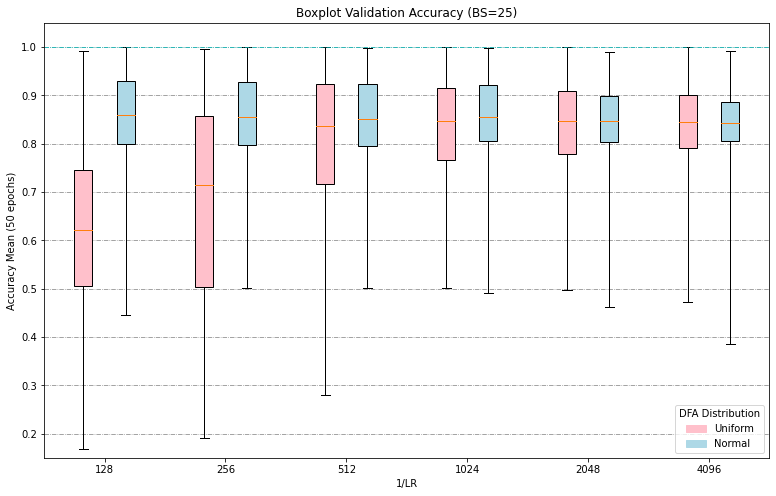

In [487]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot()
ax.set_title('Boxplot Validation Accuracy (BS=25)')

accsUniform = [accs["Uniform"][lr][0][0] for lr in lrs]
accsNormal = [accs["Normal"][lr][0][0] for lr in lrs]

uniform_plot = plt.boxplot(accsUniform, positions=np.array(np.arange(len(accsUniform)))*2.0-0.35, widths=0.3, 
                           patch_artist=True, boxprops=dict(facecolor='pink'), whis=99)
normal_plot = plt.boxplot(accsNormal, positions=np.array(np.arange(len(accsNormal)))*2.0+0.35, widths=0.3, 
                          patch_artist=True, boxprops=dict(facecolor='lightblue'), whis=99)

plt.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)    
plt.xticks(np.arange(0, (len(lrs)-0.5) * 2, 2), lrs)
plt.xlim(-1, (len(lrs)-0.5)*2)

ax.set(ylabel='Accuracy Mean (50 epochs)', xlabel='1/LR')
plt.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
plt.ylim([0.15, 1.05])

uniform_patch = mpatches.Patch(color='pink', label='Uniform')
normal_patch = mpatches.Patch(color='lightblue', label='Normal')
plt.legend(handles=[uniform_patch, normal_patch], loc=4, title='DFA Distribution')

plt.show()

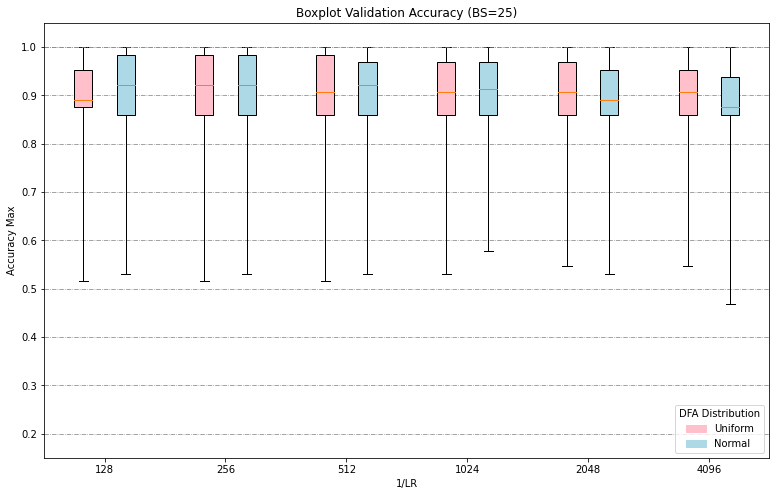

In [488]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot()
ax.set_title('Boxplot Validation Accuracy (BS=25)')

accsUniform = [accs["Uniform"][lr][0][1] for lr in lrs]
accsNormal = [accs["Normal"][lr][0][1] for lr in lrs]

uniform_plot = plt.boxplot(accsUniform, positions=np.array(np.arange(len(accsUniform)))*2.0-0.35, widths=0.3, 
                           patch_artist=True, boxprops=dict(facecolor='pink'), whis=99)
normal_plot = plt.boxplot(accsNormal, positions=np.array(np.arange(len(accsNormal)))*2.0+0.35, widths=0.3, 
                          patch_artist=True, boxprops=dict(facecolor='lightblue'), whis=99)

plt.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)    
plt.xticks(np.arange(0, (len(lrs)-0.5) * 2, 2), lrs)
plt.xlim(-1, (len(lrs)-0.5)*2)

ax.set(ylabel='Accuracy Max', xlabel='1/LR')
plt.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
plt.ylim([0.15, 1.05])

uniform_patch = mpatches.Patch(color='pink', label='Uniform')
normal_patch = mpatches.Patch(color='lightblue', label='Normal')
plt.legend(handles=[uniform_patch, normal_patch], loc=4, title='DFA Distribution')

plt.show()

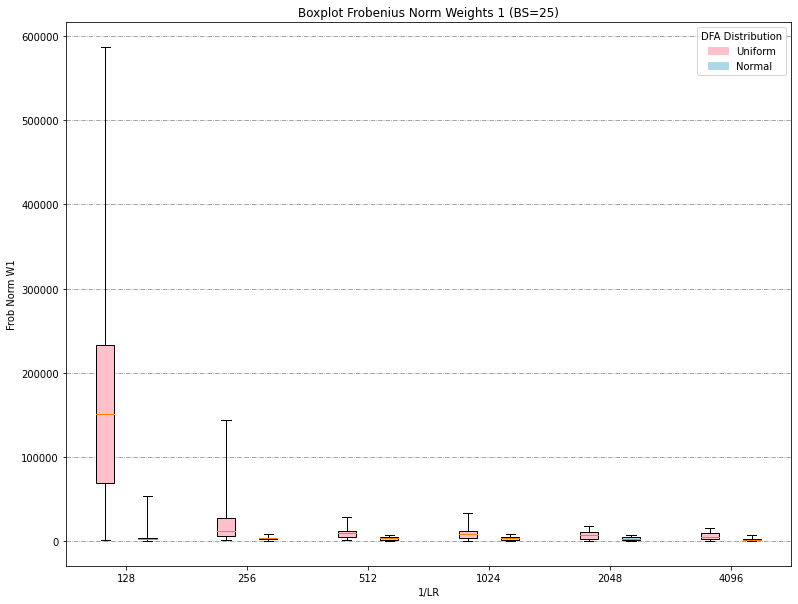

In [489]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_title('Boxplot Frobenius Norm Weights 1 (BS=25)')

accsUniform = [frobNormsW1["Uniform"][lr] for lr in lrs]
accsNormal = [frobNormsW1["Normal"][lr] for lr in lrs]

uniform_plot = plt.boxplot(accsUniform, positions=np.array(np.arange(len(accsUniform)))*2.0-0.35, widths=0.3, 
                           patch_artist=True, boxprops=dict(facecolor='pink'), whis=99)
normal_plot = plt.boxplot(accsNormal, positions=np.array(np.arange(len(accsNormal)))*2.0+0.35, widths=0.3, 
                          patch_artist=True, boxprops=dict(facecolor='lightblue'), whis=99)

plt.xticks(np.arange(0, (len(lrs)-0.5) * 2, 2), lrs)
plt.xlim(-1, (len(lrs)-0.5)*2)

ax.set(ylabel='Frob Norm W1', xlabel='1/LR')
plt.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)

uniform_patch = mpatches.Patch(color='pink', label='Uniform')
normal_patch = mpatches.Patch(color='lightblue', label='Normal')
plt.legend(handles=[uniform_patch, normal_patch], loc=1, title='DFA Distribution')

plt.show()

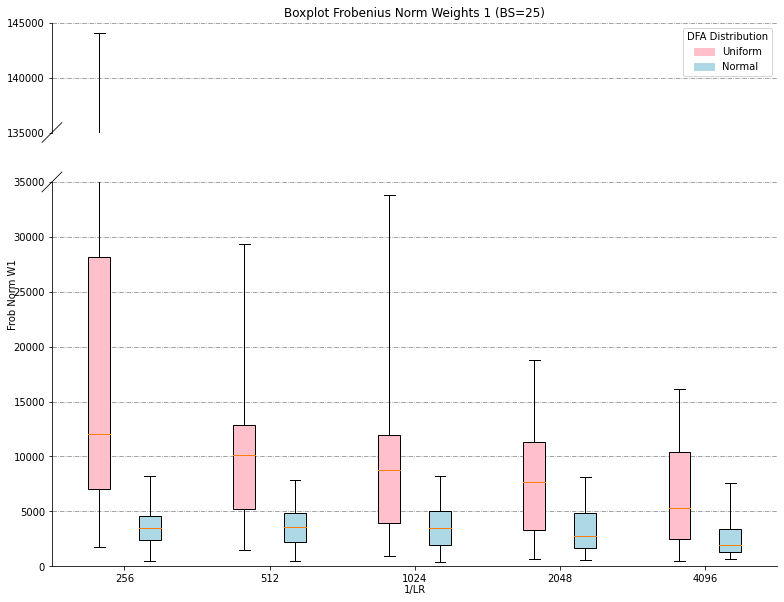

In [490]:
fig = plt.figure(figsize=(13,10))
baxes = brokenaxes(ylims=((0,35000),(135000,145000)))
baxes.set_title('Boxplot Frobenius Norm Weights 1 (BS=25)')

accsUniform = [frobNormsW1["Uniform"][lr] for lr in lrs[1:]]
accsNormal = [frobNormsW1["Normal"][lr] for lr in lrs[1:]]

baxes.boxplot(accsUniform, positions=np.array(np.arange(len(accsUniform)))*2.0-0.35, widths=0.3, 
                           patch_artist=True, boxprops=dict(facecolor='pink'), whis=99)
baxes.boxplot(accsNormal, positions=np.array(np.arange(len(accsNormal)))*2.0+0.35, widths=0.3, 
                          patch_artist=True, boxprops=dict(facecolor='lightblue'), whis=99)

baxes.set_xticks(np.arange(0, (len(lrs[1:])-0.5) * 2, 2), lrs[1:])
baxes.set_xlim(-1, (len(lrs[1:])-0.5)*2)
baxes.set_ylabel('Frob Norm W1')
baxes.set_xlabel('1/LR')

baxes.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)

uniform_patch = mpatches.Patch(color='pink', label='Uniform')
normal_patch = mpatches.Patch(color='lightblue', label='Normal')
plt.legend(handles=[uniform_patch, normal_patch], loc=1, title='DFA Distribution')

plt.show()

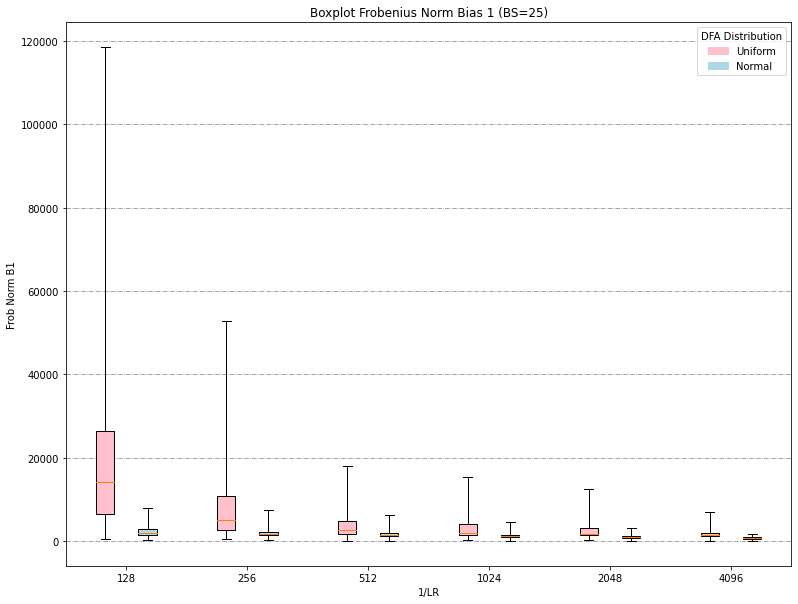

In [491]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_title('Boxplot Frobenius Norm Bias 1 (BS=25)')

accsUniform = [frobNormsB1["Uniform"][lr] for lr in lrs]
accsNormal = [frobNormsB1["Normal"][lr] for lr in lrs]
uniform_plot = plt.boxplot(accsUniform, positions=np.array(np.arange(len(accsUniform)))*2.0-0.35, widths=0.3, 
                           patch_artist=True, boxprops=dict(facecolor='pink'), whis=99)
normal_plot = plt.boxplot(accsNormal, positions=np.array(np.arange(len(accsNormal)))*2.0+0.35, widths=0.3, 
                          patch_artist=True, boxprops=dict(facecolor='lightblue'), whis=99)

plt.xticks(np.arange(0, (len(lrs)-0.5) * 2, 2), lrs)
plt.xlim(-1, (len(lrs)-0.5)*2)

ax.set(ylabel='Frob Norm B1', xlabel='1/LR')
plt.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)

uniform_patch = mpatches.Patch(color='pink', label='Uniform')
normal_patch = mpatches.Patch(color='lightblue', label='Normal')
plt.legend(handles=[uniform_patch, normal_patch], loc=1, title='DFA Distribution')

plt.show() 

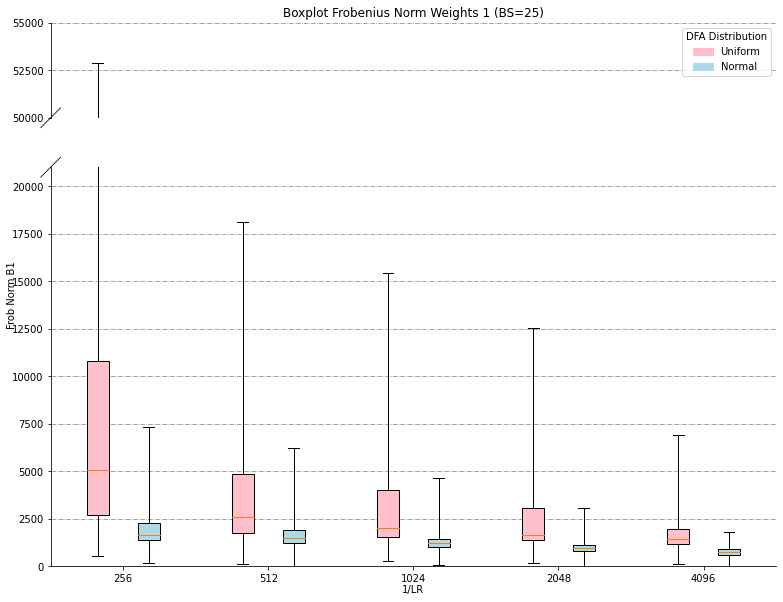

In [492]:
fig = plt.figure(figsize=(13,10))
baxes = brokenaxes(ylims=((0,21000),(50000,55000))) 
baxes.set_title('Boxplot Frobenius Norm Weights 1 (BS=25)')

accsUniform = [frobNormsB1["Uniform"][lr] for lr in lrs[1:]]
accsNormal = [frobNormsB1["Normal"][lr] for lr in lrs[1:]]

baxes.boxplot(accsUniform, positions=np.array(np.arange(len(accsUniform)))*2.0-0.35, widths=0.3, 
                           patch_artist=True, boxprops=dict(facecolor='pink'), whis=99)
baxes.boxplot(accsNormal, positions=np.array(np.arange(len(accsNormal)))*2.0+0.35, widths=0.3, 
                          patch_artist=True, boxprops=dict(facecolor='lightblue'), whis=99)

baxes.set_xticks(np.arange(0, (len(lrs[1:])-0.5) * 2, 2), lrs[1:])
baxes.set_xlim(-1, (len(lrs[1:])-0.5)*2)
baxes.set_ylabel('Frob Norm B1')
baxes.set_xlabel('1/LR')

baxes.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)

uniform_patch = mpatches.Patch(color='pink', label='Uniform')
normal_patch = mpatches.Patch(color='lightblue', label='Normal')
plt.legend(handles=[uniform_patch, normal_patch], loc=1, title='DFA Distribution')

plt.show()

### Histograms

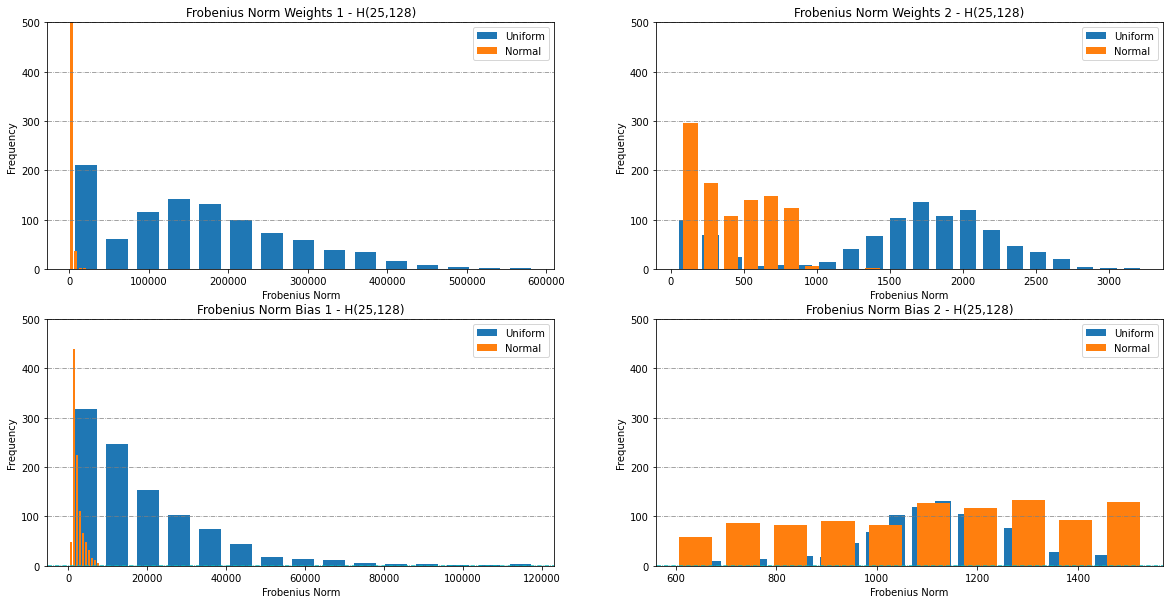

In [493]:
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(2,2)

axs[0,0].set_title('Frobenius Norm Weights 1 - H(25,128)')
axs[0,0].hist(frobNormsW1['Uniform'][128], bins=15, rwidth=0.7)
axs[0,0].hist(frobNormsW1['Normal'][128], bins=10, rwidth=0.7)

axs[1,0].set_title('Frobenius Norm Bias 1 - H(25,128)')
axs[1,0].hist(frobNormsB1['Uniform'][128], bins=15, rwidth=0.7)
axs[1,0].hist(frobNormsB1['Normal'][128], bins=10, rwidth=0.7)

axs[0,1].set_title('Frobenius Norm Weights 2 - H(25,128)')
axs[0,1].hist(frobNormsW2['Uniform'][128], bins=20, rwidth=0.7)
axs[0,1].hist(frobNormsW2['Normal'][128], bins=10, rwidth=0.7)

axs[1,1].set_title('Frobenius Norm Bias 2 - H(25,128)')
axs[1,1].hist(frobNormsB2['Uniform'][128], bins=20, rwidth=0.7)
axs[1,1].hist(frobNormsB2['Normal'][128], bins=10, rwidth=0.7)

for ax in axs.flat:
    ax.legend(['Uniform', 'Normal'])
    ax.set(xlabel='Frobenius Norm', ylabel='Frequency')
    ax.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
    ax.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)
    ax.set_ylim([0, 500])

plt.show()

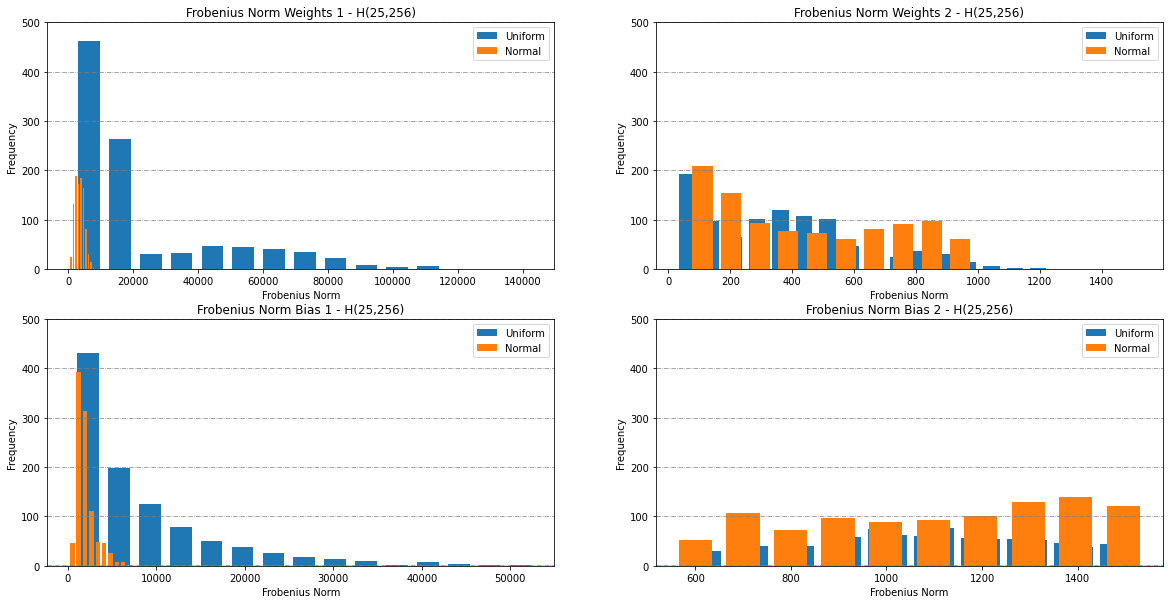

In [494]:
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(2,2)

axs[0,0].set_title('Frobenius Norm Weights 1 - H(25,256)')
axs[0,0].hist(frobNormsW1['Uniform'][256], bins=15, rwidth=0.7)
axs[0,0].hist(frobNormsW1['Normal'][256], bins=10, rwidth=0.7)

axs[1,0].set_title('Frobenius Norm Bias 1 - H(25,256)')
axs[1,0].hist(frobNormsB1['Uniform'][256], bins=15, rwidth=0.7)
axs[1,0].hist(frobNormsB1['Normal'][256], bins=10, rwidth=0.7)

axs[0,1].set_title('Frobenius Norm Weights 2 - H(25,256)')
axs[0,1].hist(frobNormsW2['Uniform'][256], bins=20, rwidth=0.7)
axs[0,1].hist(frobNormsW2['Normal'][256], bins=10, rwidth=0.7)

axs[1,1].set_title('Frobenius Norm Bias 2 - H(25,256)')
axs[1,1].hist(frobNormsB2['Uniform'][256], bins=20, rwidth=0.7)
axs[1,1].hist(frobNormsB2['Normal'][256], bins=10, rwidth=0.7)

for ax in axs.flat:
    ax.legend(['Uniform', 'Normal'])
    ax.set(xlabel='Frobenius Norm', ylabel='Frequency')
    ax.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
    ax.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)
    ax.set_ylim([0, 500])

plt.show()

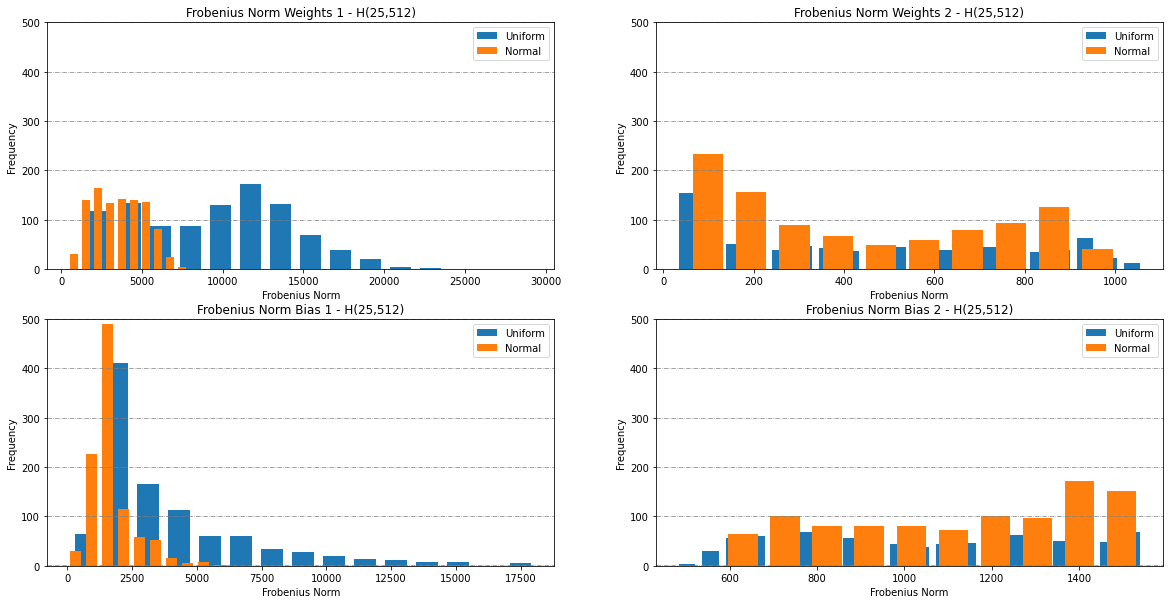

In [495]:
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(2,2)

axs[0,0].set_title('Frobenius Norm Weights 1 - H(25,512)')
axs[0,0].hist(frobNormsW1['Uniform'][512], bins=15, rwidth=0.7)
axs[0,0].hist(frobNormsW1['Normal'][512], bins=10, rwidth=0.7)

axs[1,0].set_title('Frobenius Norm Bias 1 - H(25,512)')
axs[1,0].hist(frobNormsB1['Uniform'][512], bins=15, rwidth=0.7)
axs[1,0].hist(frobNormsB1['Normal'][512], bins=10, rwidth=0.7)

axs[0,1].set_title('Frobenius Norm Weights 2 - H(25,512)')
axs[0,1].hist(frobNormsW2['Uniform'][512], bins=20, rwidth=0.7)
axs[0,1].hist(frobNormsW2['Normal'][512], bins=10, rwidth=0.7)

axs[1,1].set_title('Frobenius Norm Bias 2 - H(25,512)')
axs[1,1].hist(frobNormsB2['Uniform'][512], bins=20, rwidth=0.7)
axs[1,1].hist(frobNormsB2['Normal'][512], bins=10, rwidth=0.7)

for ax in axs.flat:
    ax.legend(['Uniform', 'Normal'])
    ax.set(xlabel='Frobenius Norm', ylabel='Frequency')
    ax.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
    ax.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)
    ax.set_ylim([0, 500])

plt.show()

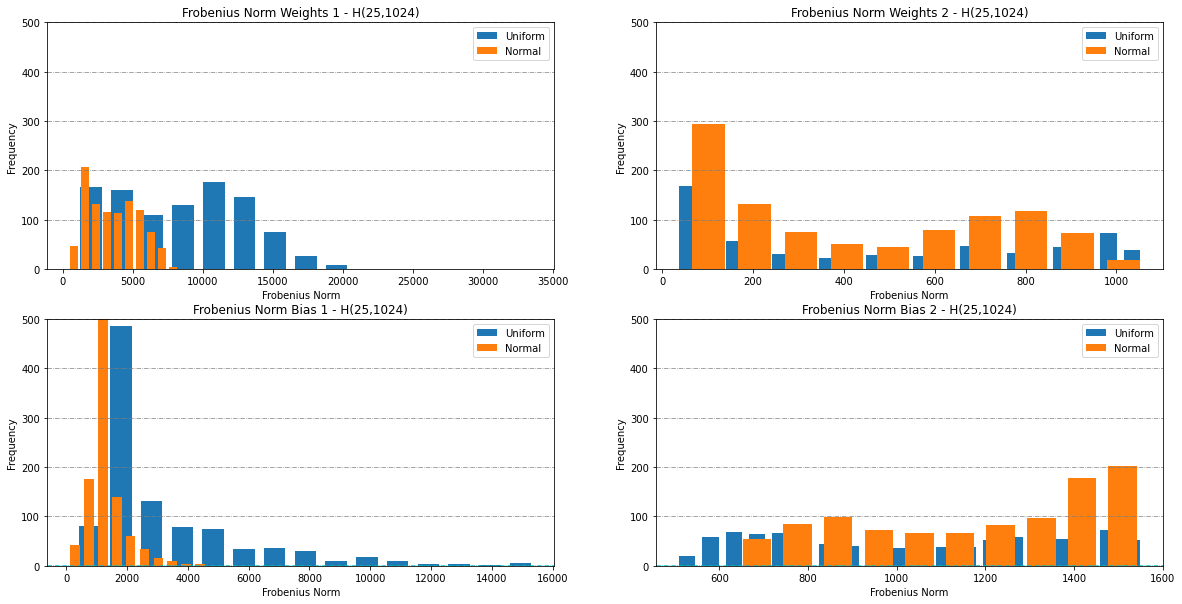

In [496]:
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(2,2)

axs[0,0].set_title('Frobenius Norm Weights 1 - H(25,1024)')
axs[0,0].hist(frobNormsW1['Uniform'][1024], bins=15, rwidth=0.7)
axs[0,0].hist(frobNormsW1['Normal'][1024], bins=10, rwidth=0.7)

axs[1,0].set_title('Frobenius Norm Bias 1 - H(25,1024)')
axs[1,0].hist(frobNormsB1['Uniform'][1024], bins=15, rwidth=0.7)
axs[1,0].hist(frobNormsB1['Normal'][1024], bins=10, rwidth=0.7)

axs[0,1].set_title('Frobenius Norm Weights 2 - H(25,1024)')
axs[0,1].hist(frobNormsW2['Uniform'][1024], bins=20, rwidth=0.7)
axs[0,1].hist(frobNormsW2['Normal'][1024], bins=10, rwidth=0.7)

axs[1,1].set_title('Frobenius Norm Bias 2 - H(25,1024)')
axs[1,1].hist(frobNormsB2['Uniform'][1024], bins=20, rwidth=0.7)
axs[1,1].hist(frobNormsB2['Normal'][1024], bins=10, rwidth=0.7)

for ax in axs.flat:
    ax.legend(['Uniform', 'Normal'])
    ax.set(xlabel='Frobenius Norm', ylabel='Frequency')
    ax.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
    ax.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)
    ax.set_ylim([0, 500])

plt.show()

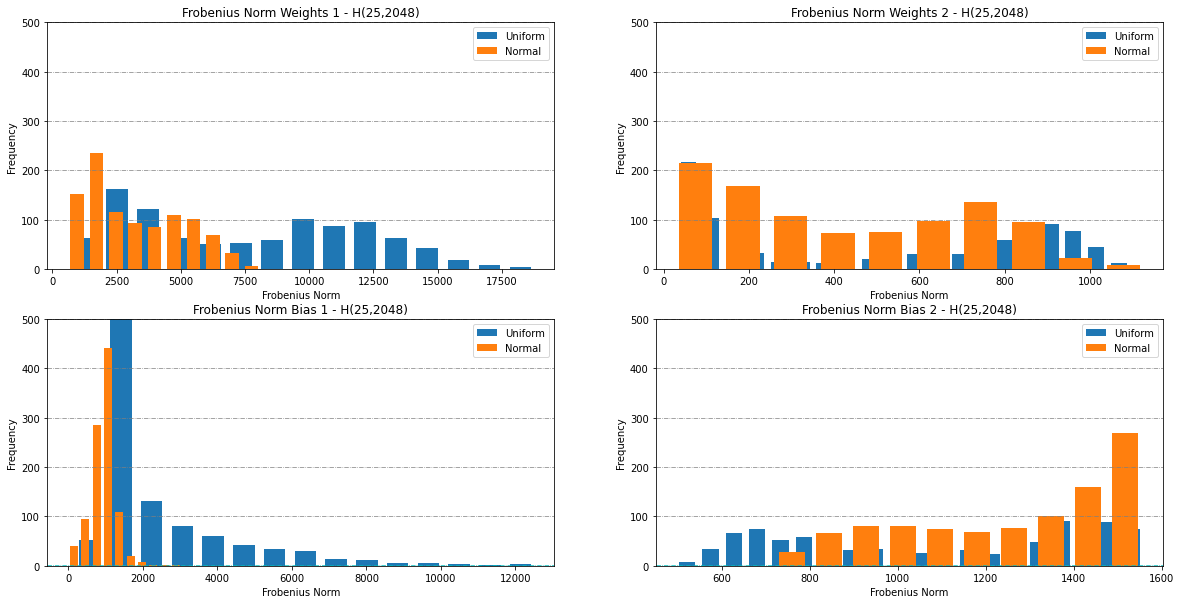

In [497]:
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(2,2)

axs[0,0].set_title('Frobenius Norm Weights 1 - H(25,2048)')
axs[0,0].hist(frobNormsW1['Uniform'][2048], bins=15, rwidth=0.7)
axs[0,0].hist(frobNormsW1['Normal'][2048], bins=10, rwidth=0.7)

axs[1,0].set_title('Frobenius Norm Bias 1 - H(25,2048)')
axs[1,0].hist(frobNormsB1['Uniform'][2048], bins=15, rwidth=0.7)
axs[1,0].hist(frobNormsB1['Normal'][2048], bins=10, rwidth=0.7)

axs[0,1].set_title('Frobenius Norm Weights 2 - H(25,2048)')
axs[0,1].hist(frobNormsW2['Uniform'][2048], bins=20, rwidth=0.7)
axs[0,1].hist(frobNormsW2['Normal'][2048], bins=10, rwidth=0.7)

axs[1,1].set_title('Frobenius Norm Bias 2 - H(25,2048)')
axs[1,1].hist(frobNormsB2['Uniform'][2048], bins=20, rwidth=0.7)
axs[1,1].hist(frobNormsB2['Normal'][2048], bins=10, rwidth=0.7)

for ax in axs.flat:
    ax.legend(['Uniform', 'Normal'])
    ax.set(xlabel='Frobenius Norm', ylabel='Frequency')
    ax.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
    ax.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)
    ax.set_ylim([0, 500])

plt.show()

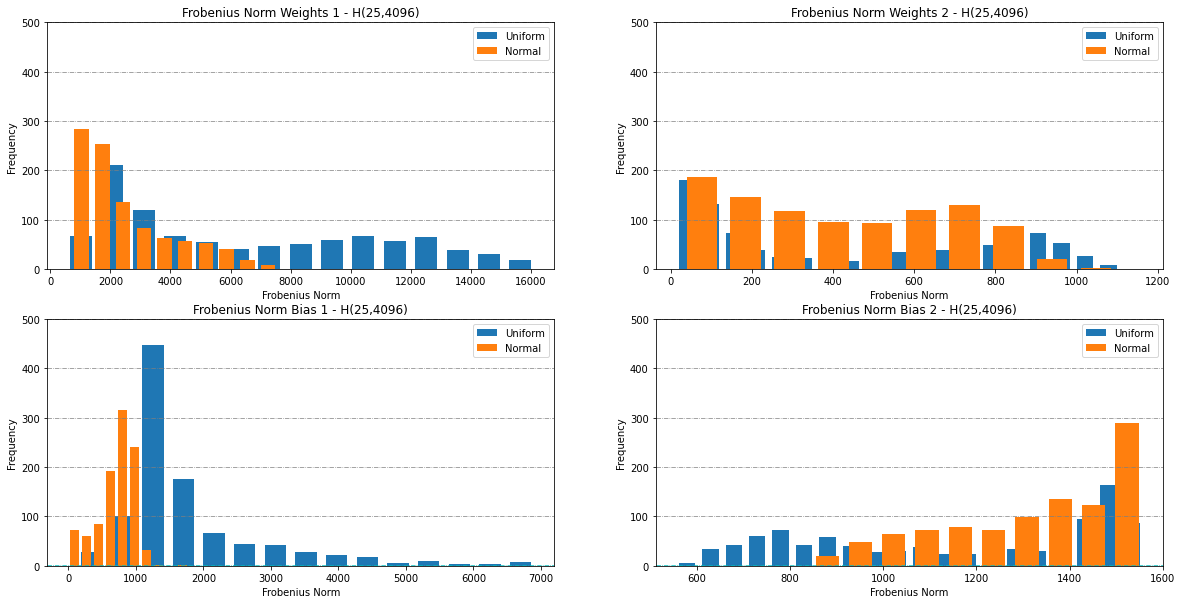

In [498]:
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(2,2)

axs[0,0].set_title('Frobenius Norm Weights 1 - H(25,4096)')
axs[0,0].hist(frobNormsW1['Uniform'][4096], bins=15, rwidth=0.7)
axs[0,0].hist(frobNormsW1['Normal'][4096], bins=10, rwidth=0.7)

axs[1,0].set_title('Frobenius Norm Bias 1 - H(25,4096)')
axs[1,0].hist(frobNormsB1['Uniform'][4096], bins=15, rwidth=0.7)
axs[1,0].hist(frobNormsB1['Normal'][4096], bins=10, rwidth=0.7)

axs[0,1].set_title('Frobenius Norm Weights 2 - H(25,4096)')
axs[0,1].hist(frobNormsW2['Uniform'][4096], bins=20, rwidth=0.7)
axs[0,1].hist(frobNormsW2['Normal'][4096], bins=10, rwidth=0.7)

axs[1,1].set_title('Frobenius Norm Bias 2 - H(25,4096)')
axs[1,1].hist(frobNormsB2['Uniform'][4096], bins=20, rwidth=0.7)
axs[1,1].hist(frobNormsB2['Normal'][4096], bins=10, rwidth=0.7)

for ax in axs.flat:
    ax.legend(['Uniform', 'Normal'])
    ax.set(xlabel='Frobenius Norm', ylabel='Frequency')
    ax.grid(True, axis='y', color = 'tab:gray', linestyle = '-.', linewidth = 0.7)
    ax.axhline(y = 1, color = 'c', linestyle = '-.', linewidth = 0.7)
    ax.set_ylim([0, 500])

plt.show()

### Scatter Plot

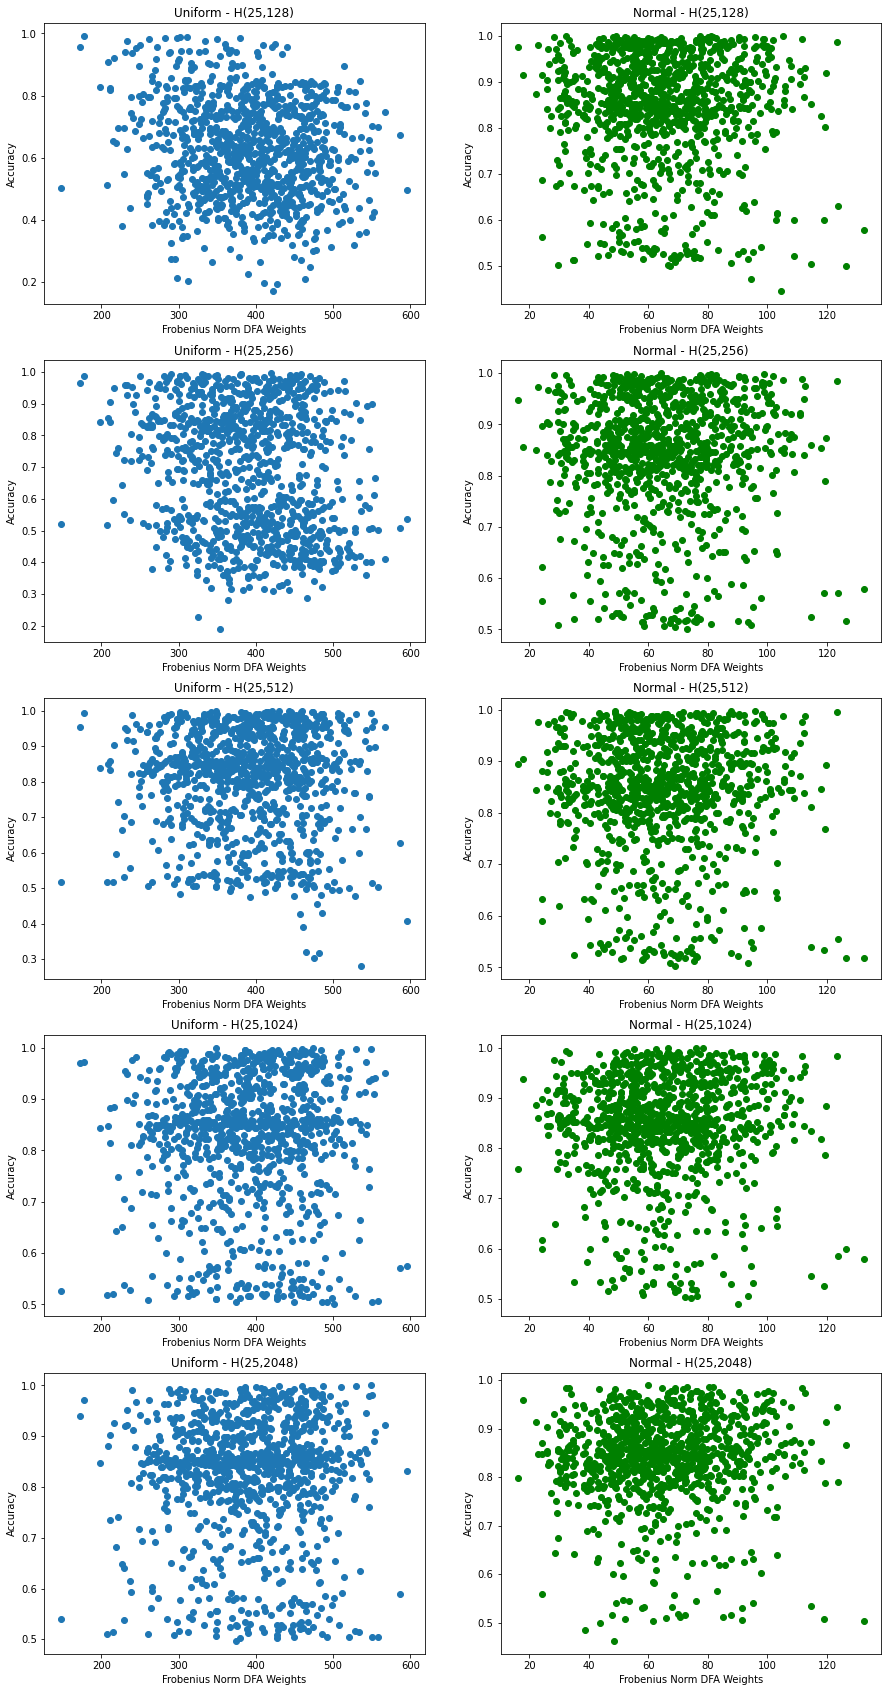

In [499]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].scatter(frobNormsDFA['Uniform'], accs['Uniform'][128][0][0])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].scatter(frobNormsDFA['Normal'], accs['Normal'][128][0][0], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].scatter(frobNormsDFA['Uniform'], accs['Uniform'][256][0][0])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].scatter(frobNormsDFA['Normal'], accs['Normal'][256][0][0], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].scatter(frobNormsDFA['Uniform'], accs['Uniform'][512][0][0])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].scatter(frobNormsDFA['Normal'], accs['Normal'][512][0][0], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].scatter(frobNormsDFA['Uniform'], accs['Uniform'][1024][0][0])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].scatter(frobNormsDFA['Normal'], accs['Normal'][1024][0][0], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].scatter(frobNormsDFA['Uniform'], accs['Uniform'][2048][0][0])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].scatter(frobNormsDFA['Normal'], accs['Normal'][2048][0][0], c='green')


for ax in axs.flat:
    ax.set(xlabel='Frobenius Norm DFA Weights', ylabel='Accuracy')

plt.show()

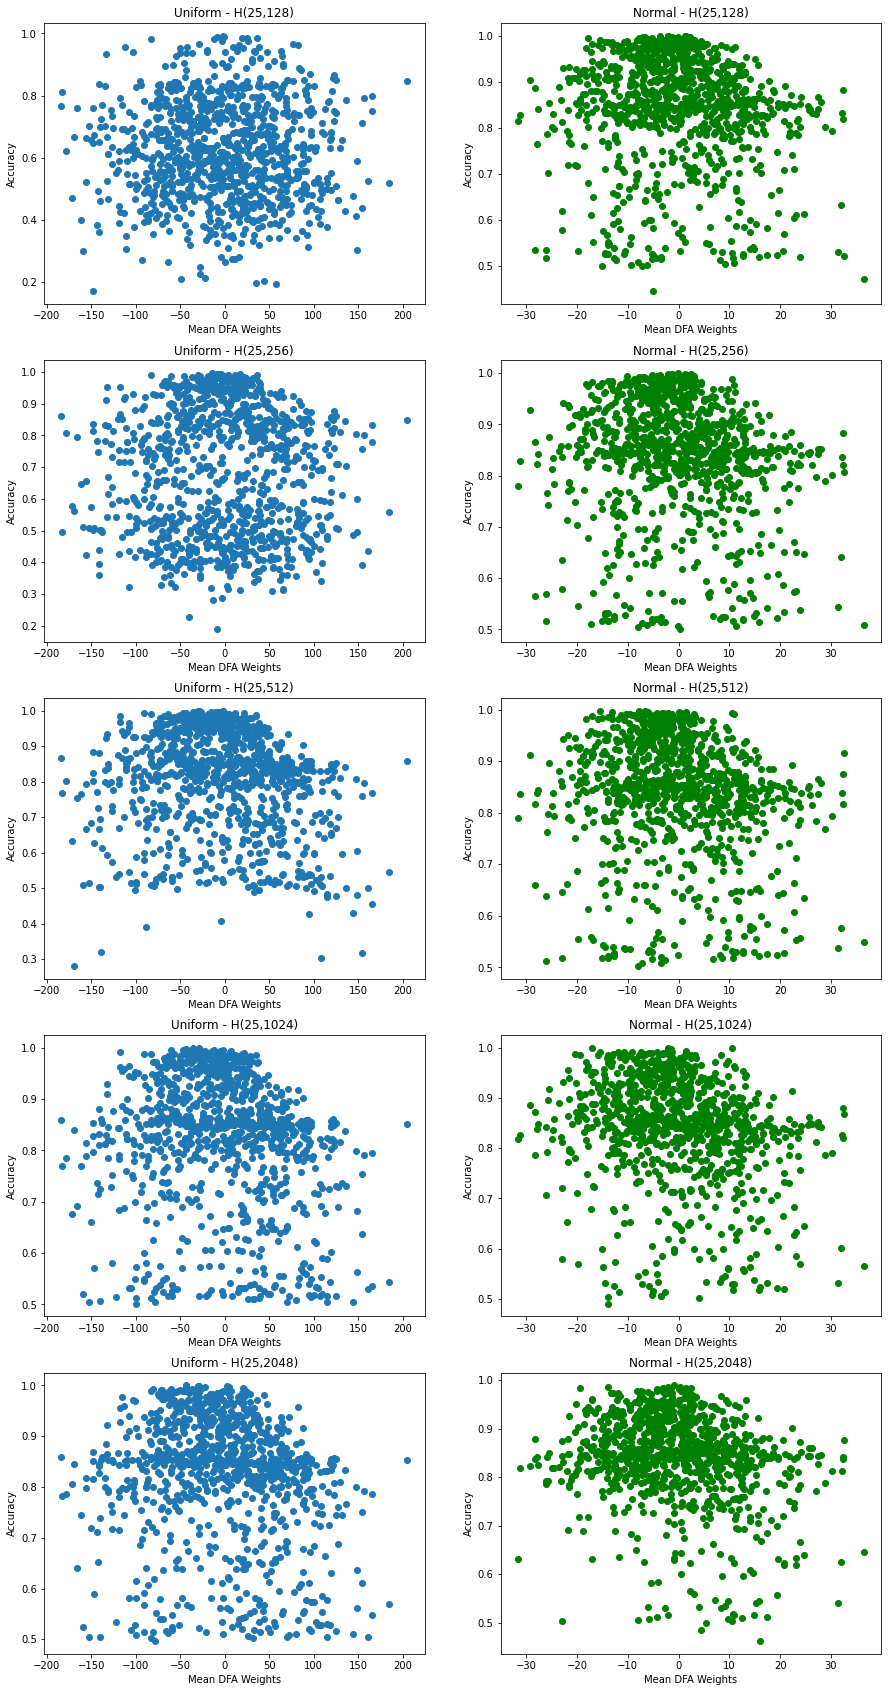

In [500]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].scatter(meansDFA['Uniform'], accs['Uniform'][128][0][0])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].scatter(meansDFA['Normal'], accs['Normal'][128][0][0], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].scatter(meansDFA['Uniform'], accs['Uniform'][256][0][0])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].scatter(meansDFA['Normal'], accs['Normal'][256][0][0], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].scatter(meansDFA['Uniform'], accs['Uniform'][512][0][0])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].scatter(meansDFA['Normal'], accs['Normal'][512][0][0], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].scatter(meansDFA['Uniform'], accs['Uniform'][1024][0][0])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].scatter(meansDFA['Normal'], accs['Normal'][1024][0][0], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].scatter(meansDFA['Uniform'], accs['Uniform'][2048][0][0])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].scatter(meansDFA['Normal'], accs['Normal'][2048][0][0], c='green')


for ax in axs.flat:
    ax.set(xlabel='Mean DFA Weights', ylabel='Accuracy')

plt.show()

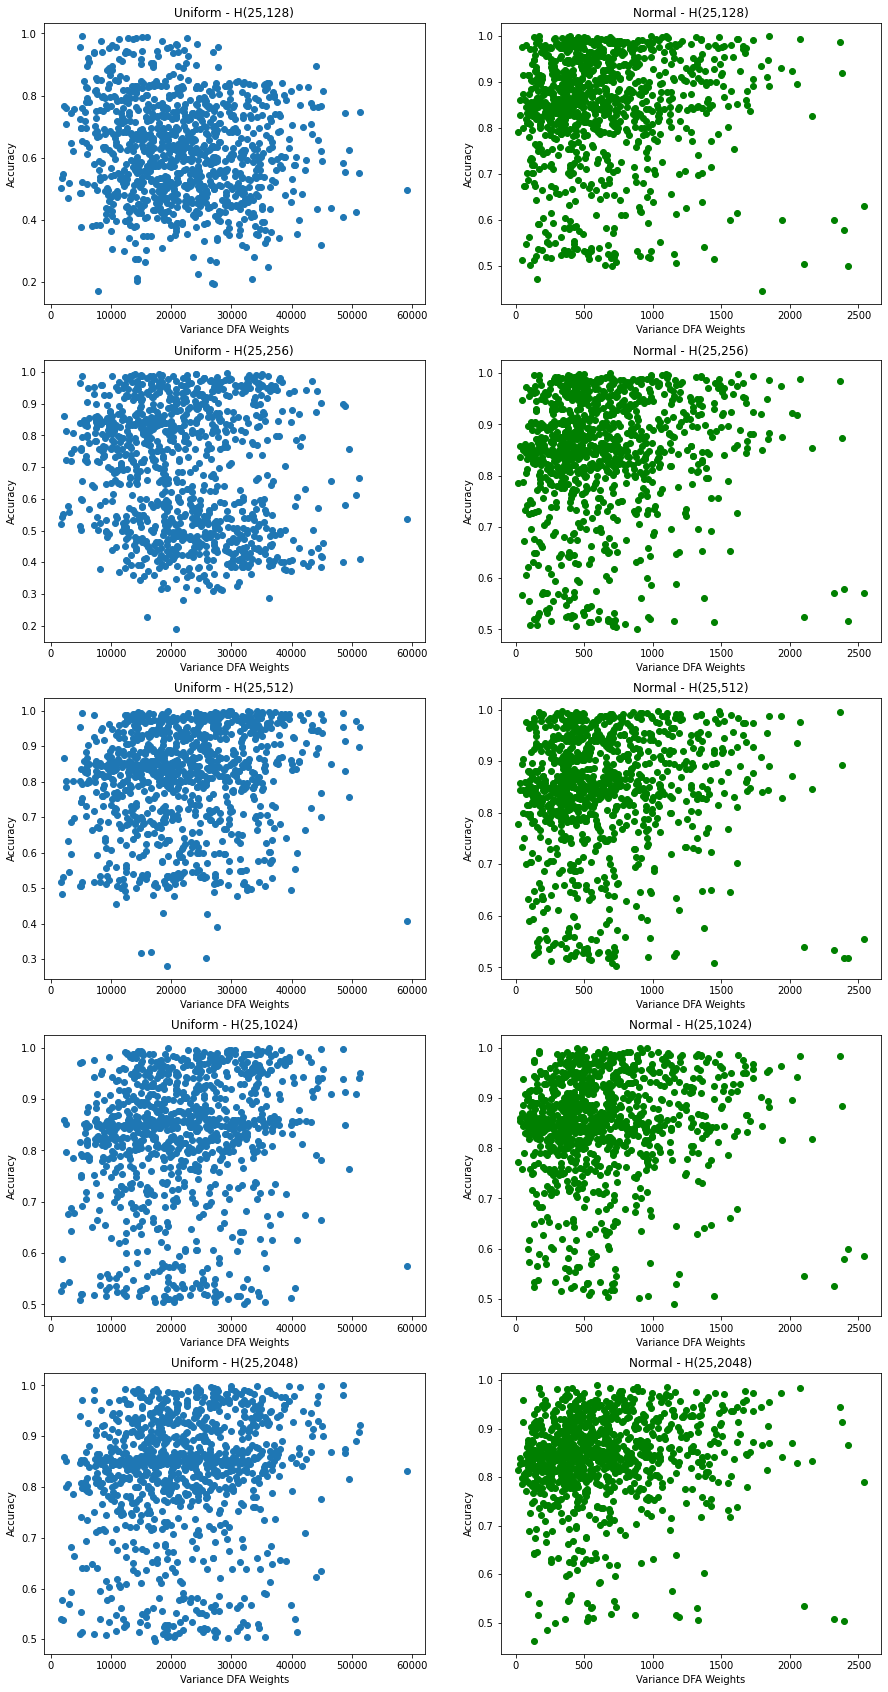

In [501]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].scatter(varsDFA['Uniform'], accs['Uniform'][128][0][0])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].scatter(varsDFA['Normal'], accs['Normal'][128][0][0], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].scatter(varsDFA['Uniform'], accs['Uniform'][256][0][0])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].scatter(varsDFA['Normal'], accs['Normal'][256][0][0], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].scatter(varsDFA['Uniform'], accs['Uniform'][512][0][0])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].scatter(varsDFA['Normal'], accs['Normal'][512][0][0], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].scatter(varsDFA['Uniform'], accs['Uniform'][1024][0][0])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].scatter(varsDFA['Normal'], accs['Normal'][1024][0][0], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].scatter(varsDFA['Uniform'], accs['Uniform'][2048][0][0])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].scatter(varsDFA['Normal'], accs['Normal'][2048][0][0], c='green')


for ax in axs.flat:
    ax.set(xlabel='Variance DFA Weights', ylabel='Accuracy')

plt.show()

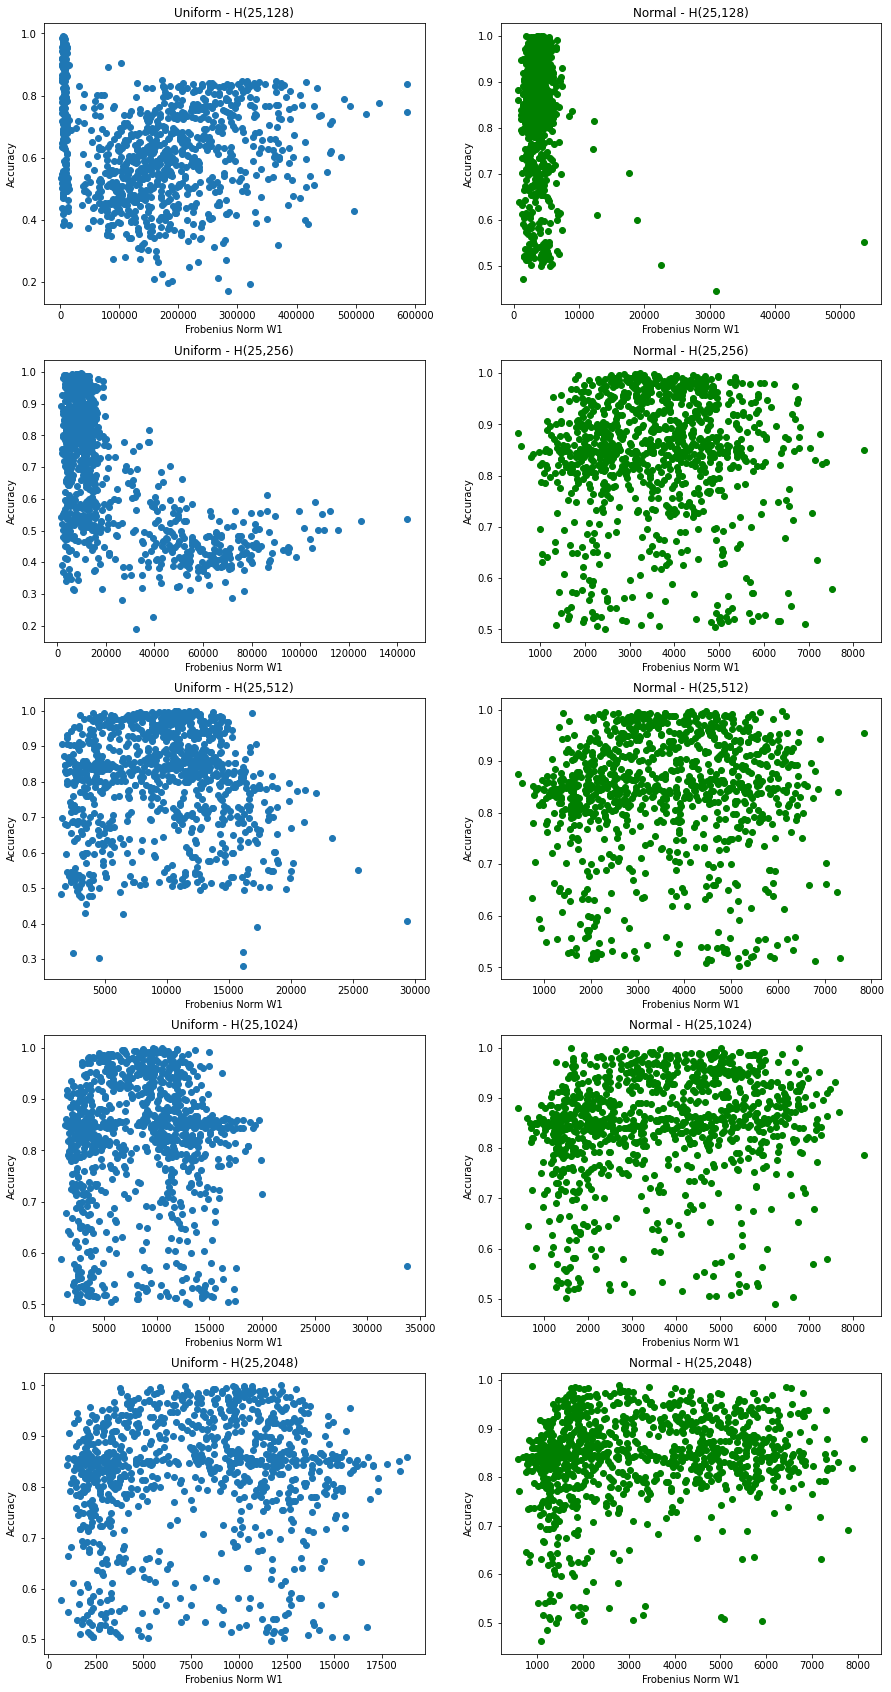

In [502]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].scatter(frobNormsW1['Uniform'][128], accs['Uniform'][128][0][0])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].scatter(frobNormsW1['Normal'][128], accs['Normal'][128][0][0], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].scatter(frobNormsW1['Uniform'][256], accs['Uniform'][256][0][0])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].scatter(frobNormsW1['Normal'][256], accs['Normal'][256][0][0], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].scatter(frobNormsW1['Uniform'][512], accs['Uniform'][512][0][0])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].scatter(frobNormsW1['Normal'][512], accs['Normal'][512][0][0], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].scatter(frobNormsW1['Uniform'][1024], accs['Uniform'][1024][0][0])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].scatter(frobNormsW1['Normal'][1024], accs['Normal'][1024][0][0], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].scatter(frobNormsW1['Uniform'][2048], accs['Uniform'][2048][0][0])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].scatter(frobNormsW1['Normal'][2048], accs['Normal'][2048][0][0], c='green')


for ax in axs.flat:
    ax.set(xlabel='Frobenius Norm W1', ylabel='Accuracy')

plt.show()

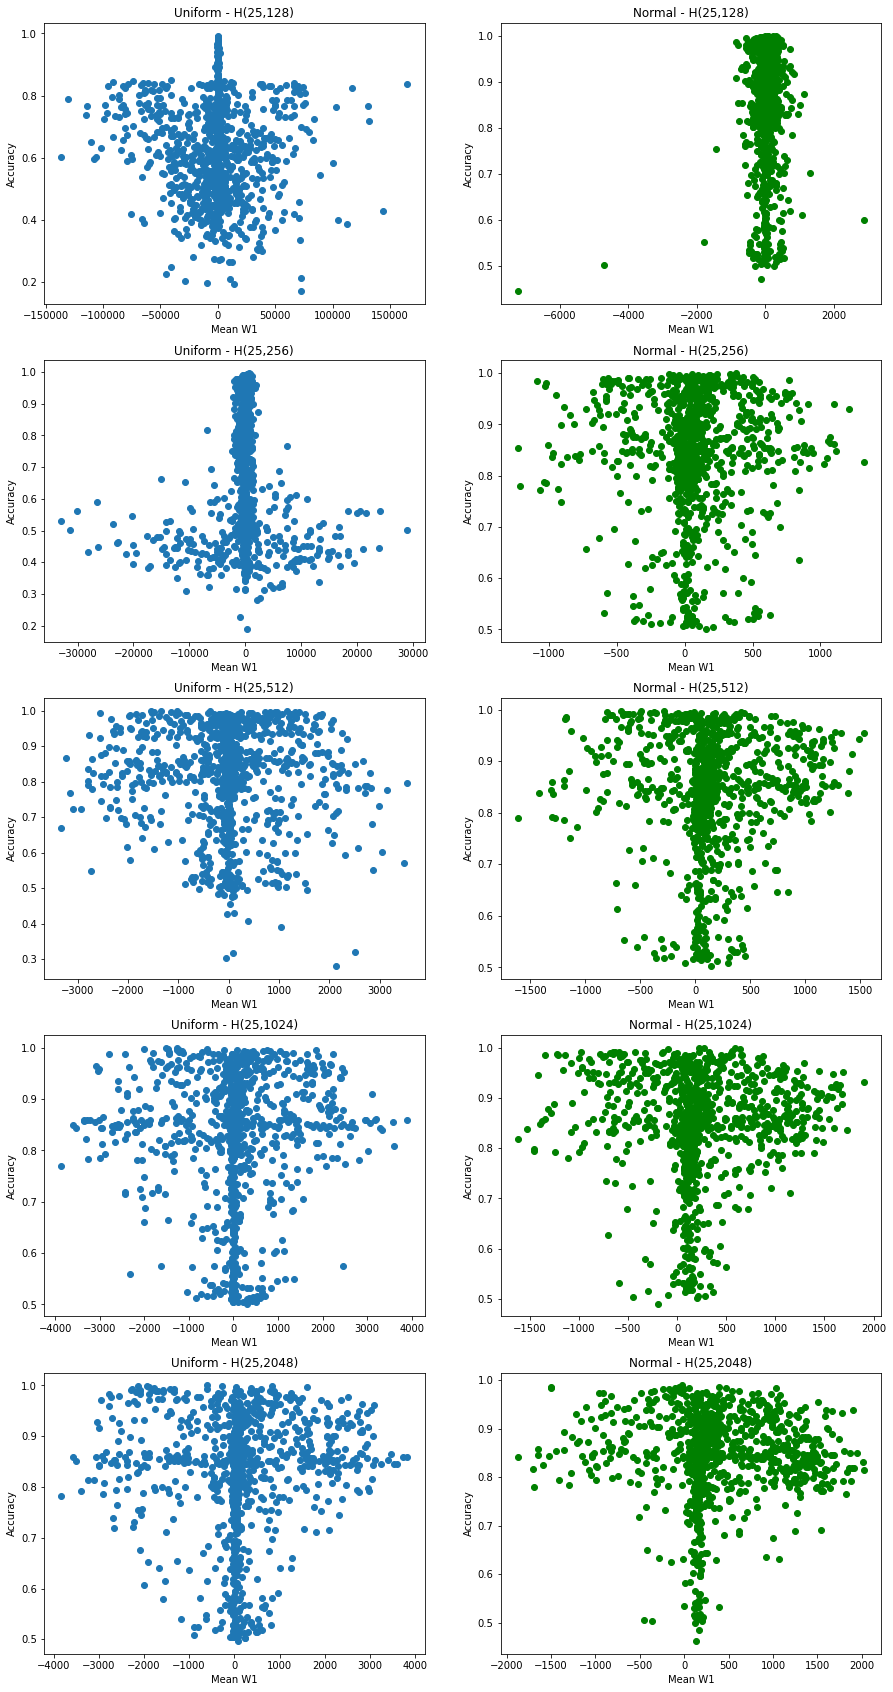

In [503]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].scatter(meansW1['Uniform'][128], accs['Uniform'][128][0][0])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].scatter(meansW1['Normal'][128], accs['Normal'][128][0][0], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].scatter(meansW1['Uniform'][256], accs['Uniform'][256][0][0])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].scatter(meansW1['Normal'][256], accs['Normal'][256][0][0], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].scatter(meansW1['Uniform'][512], accs['Uniform'][512][0][0])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].scatter(meansW1['Normal'][512], accs['Normal'][512][0][0], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].scatter(meansW1['Uniform'][1024], accs['Uniform'][1024][0][0])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].scatter(meansW1['Normal'][1024], accs['Normal'][1024][0][0], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].scatter(meansW1['Uniform'][2048], accs['Uniform'][2048][0][0])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].scatter(meansW1['Normal'][2048], accs['Normal'][2048][0][0], c='green')


for ax in axs.flat:
    ax.set(xlabel='Mean W1', ylabel='Accuracy')

plt.show()

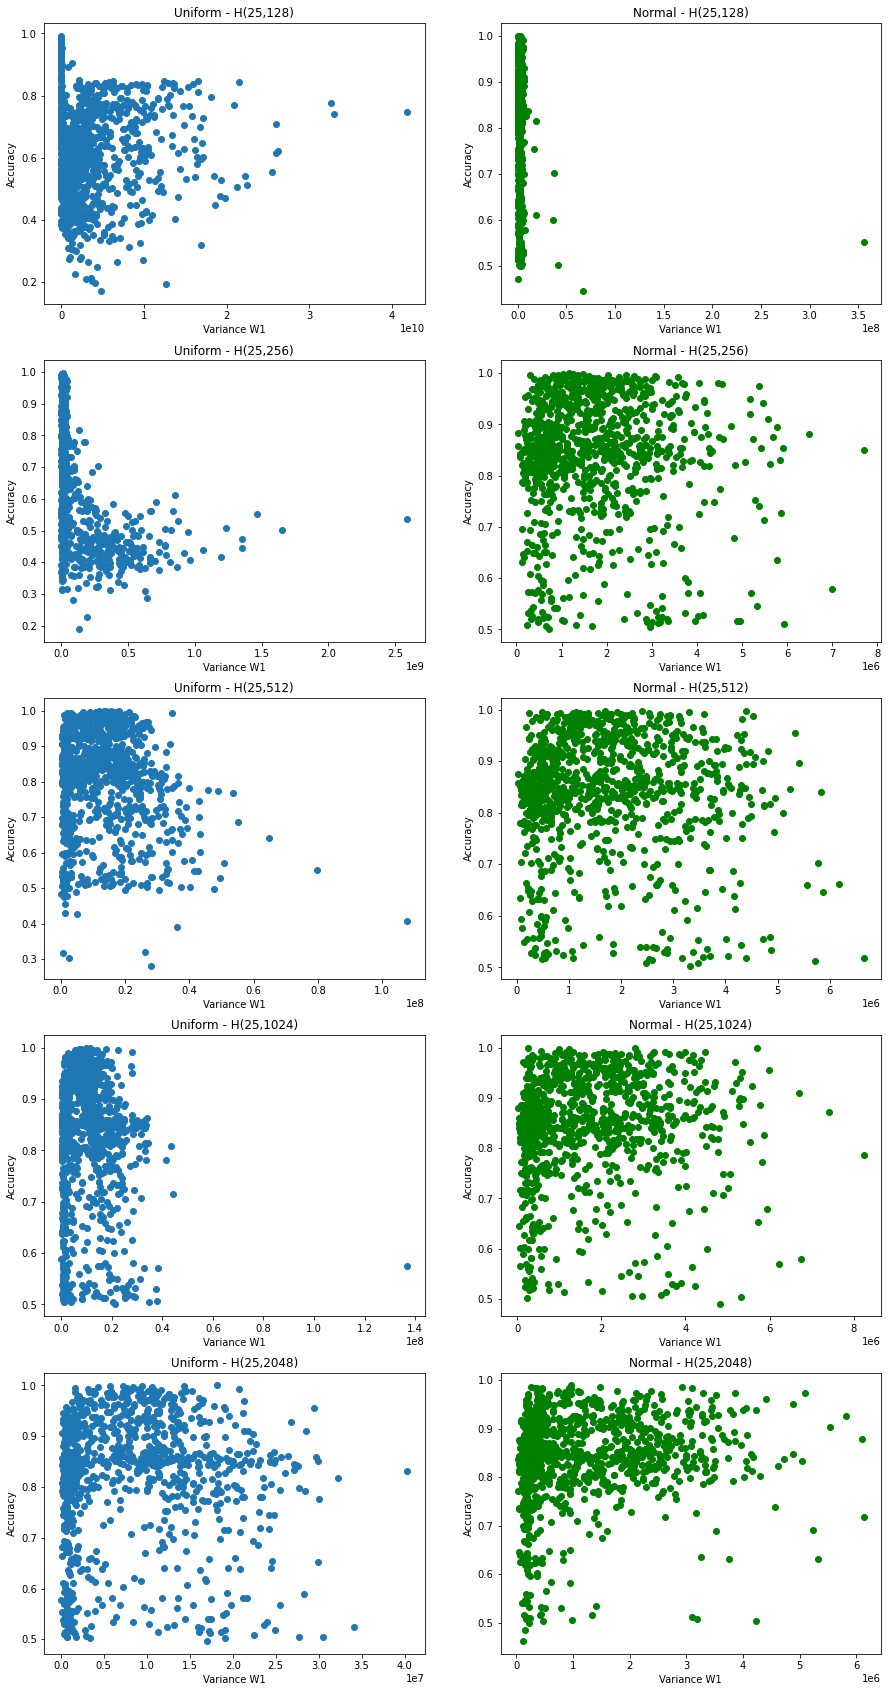

In [504]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].scatter(varsW1['Uniform'][128], accs['Uniform'][128][0][0])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].scatter(varsW1['Normal'][128], accs['Normal'][128][0][0], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].scatter(varsW1['Uniform'][256], accs['Uniform'][256][0][0])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].scatter(varsW1['Normal'][256], accs['Normal'][256][0][0], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].scatter(varsW1['Uniform'][512], accs['Uniform'][512][0][0])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].scatter(varsW1['Normal'][512], accs['Normal'][512][0][0], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].scatter(varsW1['Uniform'][1024], accs['Uniform'][1024][0][0])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].scatter(varsW1['Normal'][1024], accs['Normal'][1024][0][0], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].scatter(varsW1['Uniform'][2048], accs['Uniform'][2048][0][0])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].scatter(varsW1['Normal'][2048], accs['Normal'][2048][0][0], c='green')


for ax in axs.flat:
    ax.set(xlabel='Variance W1', ylabel='Accuracy')

plt.show()

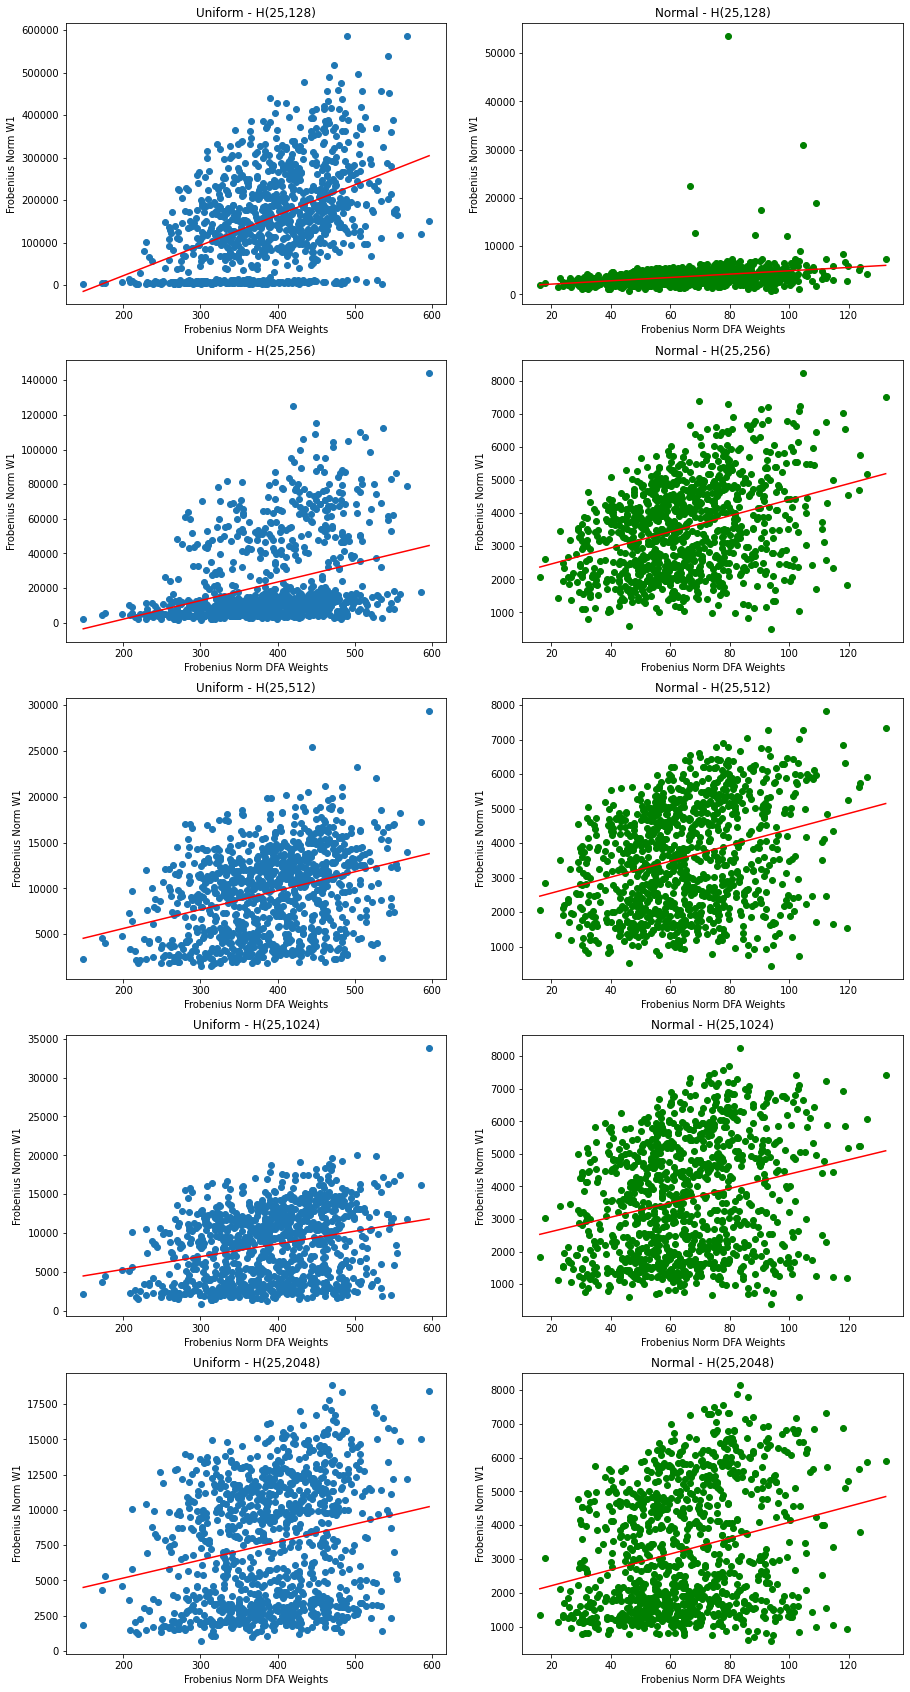

In [505]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].plot(np.unique(frobNormsDFA['Uniform']), np.poly1d(np.polyfit(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][128], 1))(np.unique(frobNormsDFA['Uniform'])), c='red')
axs[0,0].scatter(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][128])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].plot(np.unique(frobNormsDFA['Normal']), np.poly1d(np.polyfit(frobNormsDFA['Normal'], frobNormsW1['Normal'][128], 1))(np.unique(frobNormsDFA['Normal'])), c='red')
axs[0,1].scatter(frobNormsDFA['Normal'], frobNormsW1['Normal'][128], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].plot(np.unique(frobNormsDFA['Uniform']), np.poly1d(np.polyfit(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][256], 1))(np.unique(frobNormsDFA['Uniform'])), c='red')
axs[1,0].scatter(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][256])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].plot(np.unique(frobNormsDFA['Normal']), np.poly1d(np.polyfit(frobNormsDFA['Normal'], frobNormsW1['Normal'][256], 1))(np.unique(frobNormsDFA['Normal'])), c='red')
axs[1,1].scatter(frobNormsDFA['Normal'], frobNormsW1['Normal'][256], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].plot(np.unique(frobNormsDFA['Uniform']), np.poly1d(np.polyfit(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][512], 1))(np.unique(frobNormsDFA['Uniform'])), c='red')
axs[2,0].scatter(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][512])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].plot(np.unique(frobNormsDFA['Normal']), np.poly1d(np.polyfit(frobNormsDFA['Normal'], frobNormsW1['Normal'][512], 1))(np.unique(frobNormsDFA['Normal'])), c='red')
axs[2,1].scatter(frobNormsDFA['Normal'], frobNormsW1['Normal'][512], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].plot(np.unique(frobNormsDFA['Uniform']), np.poly1d(np.polyfit(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][1024], 1))(np.unique(frobNormsDFA['Uniform'])), c='red')
axs[3,0].scatter(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][1024])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].plot(np.unique(frobNormsDFA['Normal']), np.poly1d(np.polyfit(frobNormsDFA['Normal'], frobNormsW1['Normal'][1024], 1))(np.unique(frobNormsDFA['Normal'])), c='red')
axs[3,1].scatter(frobNormsDFA['Normal'], frobNormsW1['Normal'][1024], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].plot(np.unique(frobNormsDFA['Uniform']), np.poly1d(np.polyfit(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][2048], 1))(np.unique(frobNormsDFA['Uniform'])), c='red')
axs[4,0].scatter(frobNormsDFA['Uniform'], frobNormsW1['Uniform'][2048])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].plot(np.unique(frobNormsDFA['Normal']), np.poly1d(np.polyfit(frobNormsDFA['Normal'], frobNormsW1['Normal'][2048], 1))(np.unique(frobNormsDFA['Normal'])), c='red')
axs[4,1].scatter(frobNormsDFA['Normal'], frobNormsW1['Normal'][2048], c='green')


for ax in axs.flat:
    ax.set
    ax.set(xlabel='Frobenius Norm DFA Weights', ylabel='Frobenius Norm W1')

plt.show()

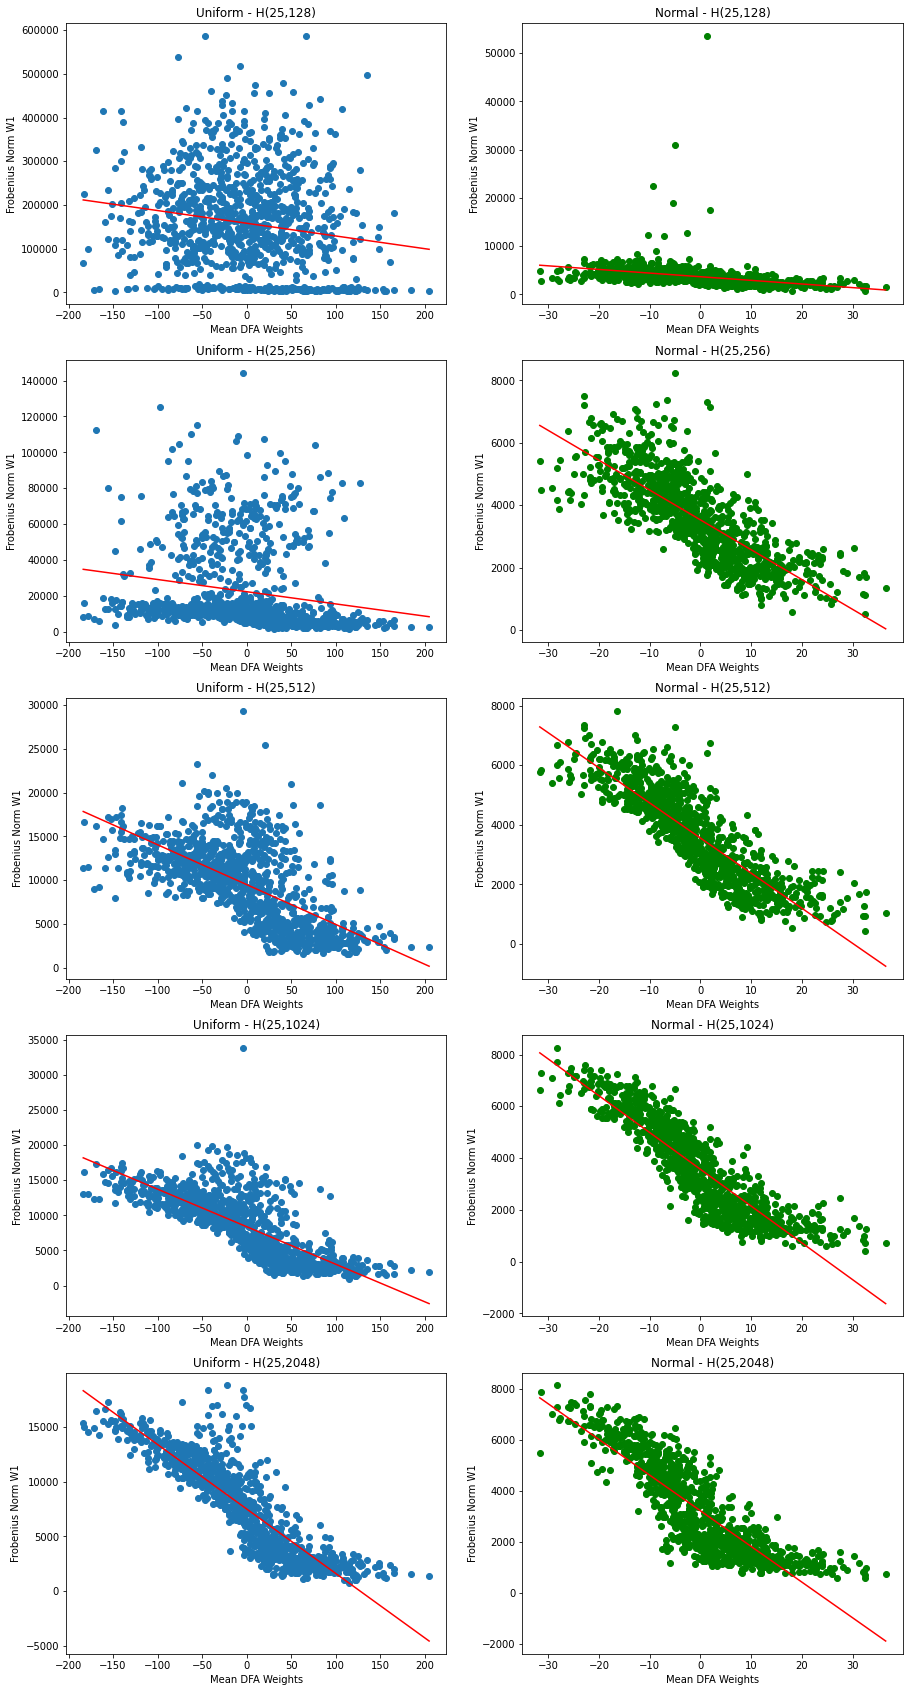

In [506]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].plot(np.unique(meansDFA['Uniform']), np.poly1d(np.polyfit(meansDFA['Uniform'], frobNormsW1['Uniform'][128], 1))(np.unique(meansDFA['Uniform'])), c='red')
axs[0,0].scatter(meansDFA['Uniform'], frobNormsW1['Uniform'][128])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].plot(np.unique(meansDFA['Normal']), np.poly1d(np.polyfit(meansDFA['Normal'], frobNormsW1['Normal'][128], 1))(np.unique(meansDFA['Normal'])), c='red')
axs[0,1].scatter(meansDFA['Normal'], frobNormsW1['Normal'][128], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].plot(np.unique(meansDFA['Uniform']), np.poly1d(np.polyfit(meansDFA['Uniform'], frobNormsW1['Uniform'][256], 1))(np.unique(meansDFA['Uniform'])), c='red')
axs[1,0].scatter(meansDFA['Uniform'], frobNormsW1['Uniform'][256])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].plot(np.unique(meansDFA['Normal']), np.poly1d(np.polyfit(meansDFA['Normal'], frobNormsW1['Normal'][256], 1))(np.unique(meansDFA['Normal'])), c='red')
axs[1,1].scatter(meansDFA['Normal'], frobNormsW1['Normal'][256], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].plot(np.unique(meansDFA['Uniform']), np.poly1d(np.polyfit(meansDFA['Uniform'], frobNormsW1['Uniform'][512], 1))(np.unique(meansDFA['Uniform'])), c='red')
axs[2,0].scatter(meansDFA['Uniform'], frobNormsW1['Uniform'][512])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].plot(np.unique(meansDFA['Normal']), np.poly1d(np.polyfit(meansDFA['Normal'], frobNormsW1['Normal'][512], 1))(np.unique(meansDFA['Normal'])), c='red')
axs[2,1].scatter(meansDFA['Normal'], frobNormsW1['Normal'][512], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].plot(np.unique(meansDFA['Uniform']), np.poly1d(np.polyfit(meansDFA['Uniform'], frobNormsW1['Uniform'][1024], 1))(np.unique(meansDFA['Uniform'])), c='red')
axs[3,0].scatter(meansDFA['Uniform'], frobNormsW1['Uniform'][1024])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].plot(np.unique(meansDFA['Normal']), np.poly1d(np.polyfit(meansDFA['Normal'], frobNormsW1['Normal'][1024], 1))(np.unique(meansDFA['Normal'])), c='red')
axs[3,1].scatter(meansDFA['Normal'], frobNormsW1['Normal'][1024], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].plot(np.unique(meansDFA['Uniform']), np.poly1d(np.polyfit(meansDFA['Uniform'], frobNormsW1['Uniform'][2048], 1))(np.unique(meansDFA['Uniform'])), c='red')
axs[4,0].scatter(meansDFA['Uniform'], frobNormsW1['Uniform'][2048])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].plot(np.unique(meansDFA['Normal']), np.poly1d(np.polyfit(meansDFA['Normal'], frobNormsW1['Normal'][2048], 1))(np.unique(meansDFA['Normal'])), c='red')
axs[4,1].scatter(meansDFA['Normal'], frobNormsW1['Normal'][2048], c='green')


for ax in axs.flat:
    ax.set(xlabel='Mean DFA Weights', ylabel='Frobenius Norm W1')

plt.show()

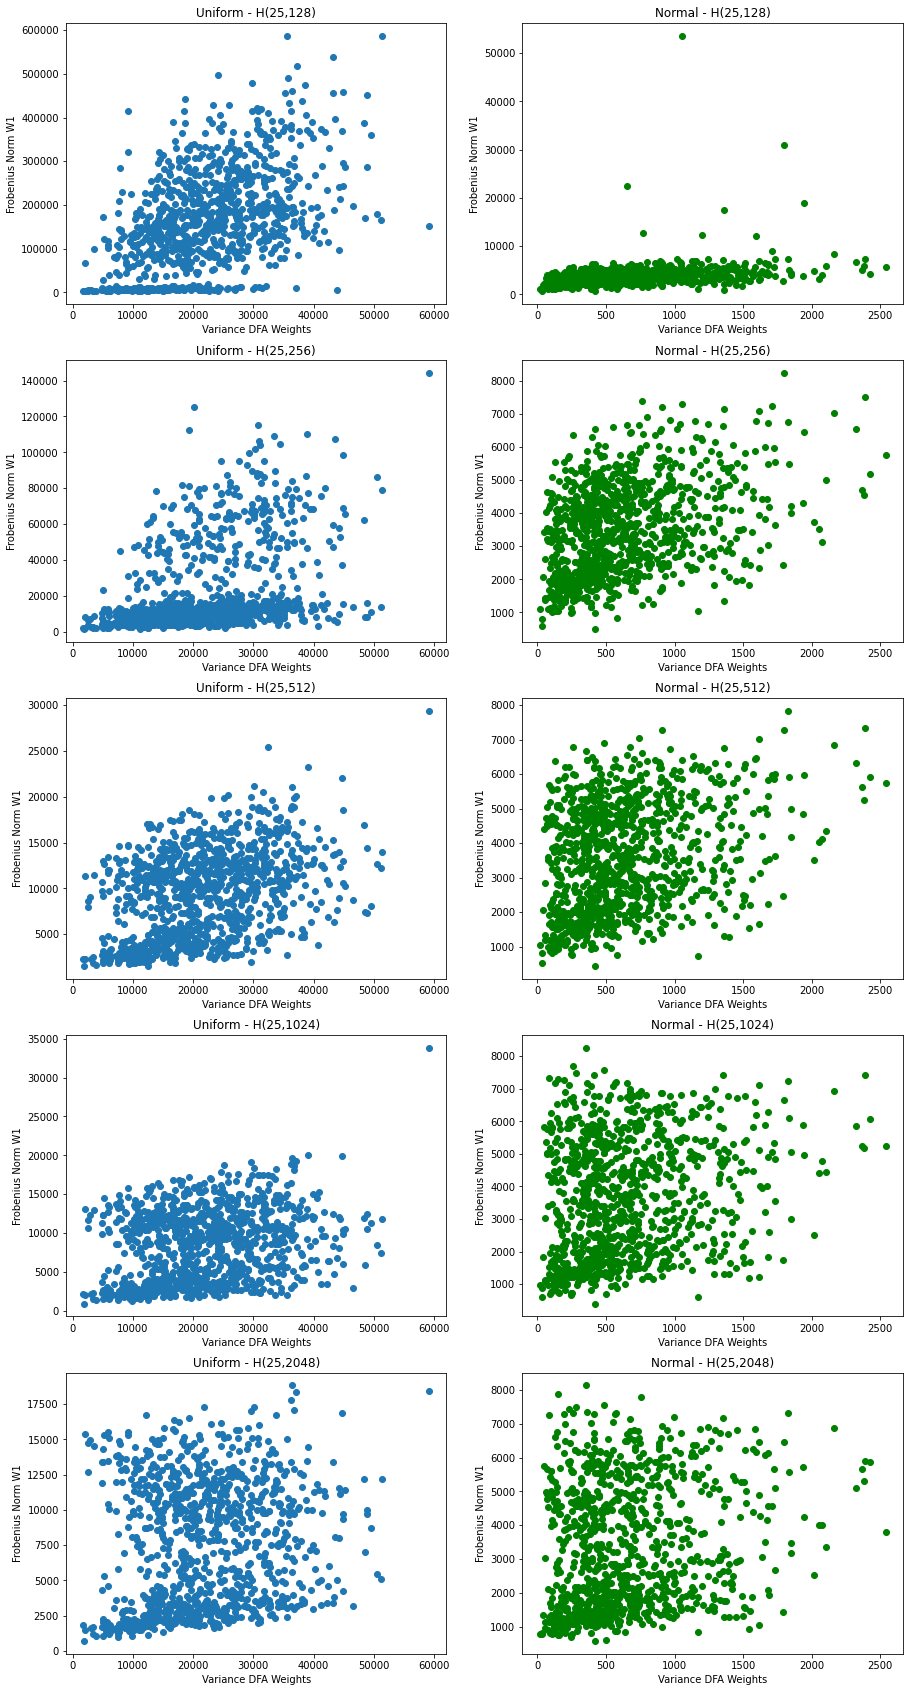

In [507]:
fig = plt.figure(figsize=(15,30))
axs = fig.subplots(5,2)

axs[0,0].set_title('Uniform - H(25,128)')
axs[0,0].scatter(varsDFA['Uniform'], frobNormsW1['Uniform'][128])

axs[0,1].set_title('Normal - H(25,128)')
axs[0,1].scatter(varsDFA['Normal'], frobNormsW1['Normal'][128], c='green')

axs[1,0].set_title('Uniform - H(25,256)')
axs[1,0].scatter(varsDFA['Uniform'], frobNormsW1['Uniform'][256])

axs[1,1].set_title('Normal - H(25,256)')
axs[1,1].scatter(varsDFA['Normal'], frobNormsW1['Normal'][256], c='green')

axs[2,0].set_title('Uniform - H(25,512)')
axs[2,0].scatter(varsDFA['Uniform'], frobNormsW1['Uniform'][512])

axs[2,1].set_title('Normal - H(25,512)')
axs[2,1].scatter(varsDFA['Normal'], frobNormsW1['Normal'][512], c='green')

axs[3,0].set_title('Uniform - H(25,1024)')
axs[3,0].scatter(varsDFA['Uniform'], frobNormsW1['Uniform'][1024])

axs[3,1].set_title('Normal - H(25,1024)')
axs[3,1].scatter(varsDFA['Normal'], frobNormsW1['Normal'][1024], c='green')

axs[4,0].set_title('Uniform - H(25,2048)')
axs[4,0].scatter(varsDFA['Uniform'], frobNormsW1['Uniform'][2048])

axs[4,1].set_title('Normal - H(25,2048)')
axs[4,1].scatter(varsDFA['Normal'], frobNormsW1['Normal'][2048], c='green')


for ax in axs.flat:
    ax.set(xlabel='Variance DFA Weights', ylabel='Frobenius Norm W1')

plt.show()